Attempt to finetune DistilBERT-base-uncased for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [15]:
import pandas as pd
import numpy as np
from datasets import load_from_disk

aug_stream_data = load_from_disk("data/processed/aug_stream_data")


In [16]:
from transformers import AutoTokenizer
import torch

model_id = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [17]:
train_dataset = aug_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = aug_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


In [18]:
labels = aug_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


In [20]:
from huggingface_hub import notebook_login
notebook_login()


In [21]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score, f1_score

batch_size = 16
num_train_epochs = 5
learning_rate = 2e-5
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_id}-finetuned-arxiv"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size // 2,weight_decay=0.01,
                                  eval_strategy="steps",
                                  eval_steps=100,
                                  save_strategy="steps",
                                  save_total_limit=5,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  push_to_hub=True,
                                  log_level="error")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


In [22]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_weighted_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [23]:
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
100,No log,1.479348,0.197309,0.225195
200,No log,1.082523,0.382766,0.429285
300,No log,0.923000,0.445253,0.471897
400,No log,0.834898,0.446428,0.498626
500,No log,0.750671,0.494440,0.533156
600,No log,0.823556,0.462852,0.547012
700,No log,0.790497,0.475823,0.573498
800,1.408200,0.720881,0.492001,0.558168
900,1.408200,0.719532,0.525398,0.591199
1000,1.408200,0.745035,0.516736,0.606328


TrainOutput(global_step=3750, training_loss=0.6866696537017822, metrics={'train_runtime': 942.9098, 'train_samples_per_second': 63.569, 'train_steps_per_second': 3.977, 'total_flos': 7942644681523200.0, 'train_loss': 0.6866696537017822, 'epoch': 5.0})

In [24]:
preds_output = trainer.predict(eval_dataset)


In [25]:
preds_output.metrics


{'test_loss': 0.6240399479866028,
 'test_macro_f1': 0.6420053286576773,
 'test_balanced_accuracy': 0.7208261336092375,
 'test_runtime': 6.9953,
 'test_samples_per_second': 238.876,
 'test_steps_per_second': 29.877}

In [26]:
y_preds = np.argmax(preds_output.predictions, axis=1)


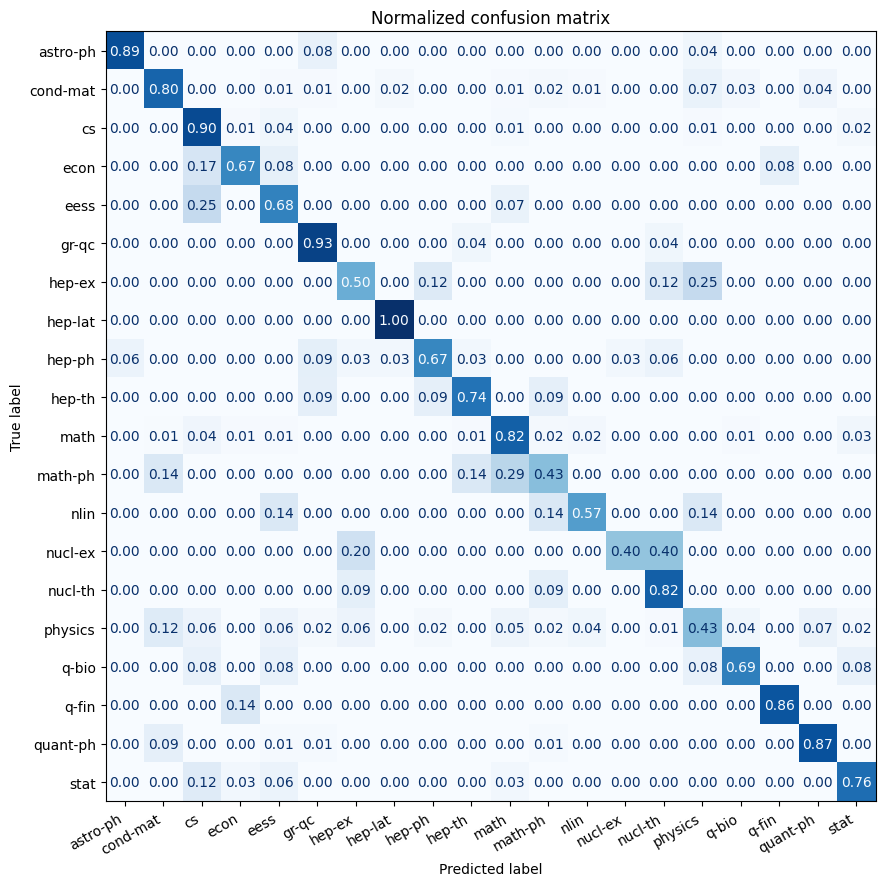

In [27]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


In [ ]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [ ]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)
